# Vacation Rental Market Analysis - Part 2 Data Analysis

## Introduction

Two files are given for the exercise.  The listing file contains data regarding attributes of the listing, such as location, number of bed/bath etc.  The second file scraped_data.csv (thereafter renamed 'price) in the workbook, contains availability and price data for listings for April and May 2018, scraped daily during time period from 3/15/18 to 5/31/18.  There are 8,445 listings given.  The goal of the analysis is to assess the pricing, revenue, occupancy ratio of comparable properties. 

This notebook contains analysis of the data.  The code to clean the data is in a separate notebook.

## What data would you exclude from analysis for being unreliable or potentially a block instead of an actual booking?

The price should be based on what a customer paid to stay in a property, not what the host wishes to charge.  The biggest obstacle in this dataset is to distinguish days that are blocked by hosts (therefore marked as unavailable), from days that are actually unavailable due to booking.  The following logics are utilized to clean the data: <br>
1. If the unit has never had any availability during April and May.  This means that the property is most likley blocked out by the host.  It is very unlikely to have properties with 100% occupancy rate.  Exclude these from analysis.  About 1,075 properties are under this category.
2. If the unit always have availability (did not have any zero in availability). Remove these from analysis. They are not priced right. About 244 properties are in this category.  
3. Determine the booking date for each property, which can be inferred by the date that the flag for availability changed from 1 to 0.  If a property has more than 14 days that are changed from available to not-available on the same day, it is most likely that the property is blocked by the host.  Exclude these from analysis.  14 days was chosen because approximately 40% of bookings are of 1 day stays, 14 days would cover ast least 80% of the stays.  
4. Since price continue to change after day of booking.  Obtain the scraped-price on the booking date of each stay. 
5. Majority of the bookings are booked within 11 days of the stay dates.  However, many of the bookings are made way ahead of time.  Due to limitation of data, (only have data scraped from 3/15), it is not possible to determine the booking date for all the properties.  Additional steps need to be taken to filter out questionable data. The approach used is to establish a confidence interval based on the price that we are more certain about (the ones with booking date).  For each stay date that we do not have reliable booking date data, if the price scraped on the day of stay is 15% above the maximum rate of the property ever charged, or $25 above the maximum rate for that property ever charged, mark the booking as unreliable and exclude them from the analysis.  
6. The last layer of QA is if the price is above 95% percentile for the property type (based on number of bedrooms), exclude the listing from the anlaysis.  


#### How is price determined?

The analysis of this notebook will focus on price history that passes all of the above QA process.  It will only focus on actual bookings.  One assumption of pricing is that the actual price paid by the customers are the price scrapped on the booking date, even if the price continues to change even after a booking is made.  For the stays where we cannot determine the booking date, the price used in the analysis is based on the price scraped on the stay date.  The assumption is that the price scrapped on the stay date will be  the lowest that the host is willing to accept, and will not be too far off from the average booking rate for that property.  Even if the price may not be accurate, it is a more conservative guess.  <br>

Another consideration is cleaning fee.  Some properties are priced low, and charges an exuberant amount of cleaning fee.  This is a common tatic to shown your property as a cheap one, until the user inputs and dates, and then cleaning fee is shown. To make pricing more comparable, the analysis assumes a 3-night stay and pricing will be daily rate + 1/3 cleaning fee. 

A successful host will have to balance between nightly rate v.s cleaning fee.  Having a low nightly rate will entice more users to click on the property.  However, if most of the users book a long stay, the host will lose out on cleaning fee revenue.  Being able to forecast the length of stay for each property will help determine the optimal balance.  

## What is a good approach to estimate occupancy and revenue per unit?

Occupancy is estimated based on the number of days booked relative to the number of days in the month. For the properties that are added in the middle of the month, the denominator are adjusted based on the start date of the property.<br>


To estimate revenue per unit, one factor to consider is the number of separate bookings made during the month, as cleaning fee might be a big component of the revenue.   The revenue is calculated based on nightly rate + cleaning fee per booking.  <Br>


To estimate the number of bookings during a month, I calculated the number of unique booking dates for each month.  The drawback of this approach is that there are instances where two bookings are made on the same day, even though the days are consecutive. (for example, A made booking for 4/1 to 4/3 on 3/31, while B also made booking on 3/31 for 4/4-4/5) <br>

One way to check the validity of this approach is to verify with known data.  Below is some data for WanderJaunt.  Please see if it makes sense.

In [14]:
cols = ['host_name', 'listing', 'city', 'num_bookedDays_Apr', 'num_bookedDays_May', 'occupancy_ratio_Apr', 'occupancy_ratio_May',
       'occupancy_ratio_all', 'Apr_num_booking', 'May_num_booking',
       'Apr_rev_ex_clean', 'May_rev_ex_clean', 'Apr_cleaning_revenue',
       'May_cleaning_revenue', 'Apr_total_revenue', 'May_total_revenue']

temp = df.loc[df['host_name'] == 'WanderJaunt', cols]
temp = temp.sort_values(by = ['May_num_booking'], ascending = False)
temp[:5]

,host_name,listing,city,num_bookedDays_Apr,num_bookedDays_May,occupancy_ratio_Apr,occupancy_ratio_May,occupancy_ratio_all,Apr_num_booking,May_num_booking,Apr_rev_ex_clean,May_rev_ex_clean,Apr_cleaning_revenue,May_cleaning_revenue,Apr_total_revenue,May_total_revenue
4396,WanderJaunt,https://www.airbnb.com/rooms/18057796,phoenix,25.0,28.0,0.833333,0.903226,0.868852,6.0,11.0,2967.0,1984.0,540.0,990.0,3507.0,2974.0
5548,WanderJaunt,https://www.airbnb.com/rooms/20913327,phoenix,20.0,25.0,0.666667,0.806452,0.737705,3.0,10.0,2275.0,1747.0,270.0,900.0,2545.0,2647.0
16,WanderJaunt,https://www.airbnb.com/rooms/16603819,scottsdale,22.0,26.0,0.733333,0.838710,0.786885,6.0,9.0,2351.0,2368.0,690.0,1035.0,3041.0,3403.0
4377,WanderJaunt,https://www.airbnb.com/rooms/17994759,phoenix,23.0,28.0,0.766667,0.903226,0.836066,9.0,9.0,2520.0,1856.0,810.0,810.0,3330.0,2666.0
6880,WanderJaunt,https://www.airbnb.com/rooms/22491962,phoenix,20.0,26.0,0.666667,0.838710,0.754098,5.0,9.0,2202.0,1748.0,450.0,810.0,2652.0,2558.0


## Which month appears to be more profitable? April or May?

First off, April data is less accurate than May data due to the fact of not being able to determine the booking date, therefore, the number of separate stays could be understated for April data.  If the number of stays are understated, the April cleaning revenue will be understated as well.  Please keep this in mind when reviewing the comparison.

We will use WanderJaunt data to assess the validity of the calculation.  6 properties are addeded in April and 9 properties are added in May.  We will exlude properties with partial months from the anlaysis.  The properties are assumed to be new property when no previous scraping history are available.  Even if the assumption may not be always true, we don't have the data to analyze them anyway.

From the available data, April seem to be more profitable than May, mostly due to that price in April on average is higher than May.

In [15]:
temp = df.loc[(df['host_name'] == 'WanderJaunt') & (df['scraped_date_min'] == '2018-03-15')]
x = (temp['Apr_rev_ex_clean'] > temp['May_rev_ex_clean']).sum()
print('% of properties with April Revenue greater than May revenue excluding cleaning fee:{:.2f}'.format(x/len(temp)*100))
x = (temp['Apr_total_revenue'] > temp['May_total_revenue']).sum()
print('% of properties with April Revenue greater than May revenue including cleaning fee:{:.2f}'.format(x/len(temp)*100))

x = temp['occupancy_ratio_Apr'].mean()
print('Mean Occupancy Ratio in April:{:.2f}'.format(x))
x = temp['occupancy_ratio_May'].mean()
print('Mean Occupancy Ratio in May:{:.2f}'.format(x))

x = temp['Apr_rev_ex_clean'].mean()
print('Mean Revenue ex-cleaning fee in April:{:.2f}'.format(x))
x = temp['May_rev_ex_clean'].mean()
print('Mean Revenue ex-cleaning fee in May:{:.2f}'.format(x))

x = temp['meanPriceMonth_Apr'].mean()
print('Mean price ex-cleaning fee in April:{:.2f}'.format(x))
x = temp['meanPriceMonth_May'].mean()
print('Mean price ex-cleaning fee in May:{:.2f}'.format(x))

% of properties with April Revenue greater than May revenue excluding cleaning fee:72.73
% of properties with April Revenue greater than May revenue including cleaning fee:54.55
Mean Occupancy Ratio in April:0.62
Mean Occupancy Ratio in May:0.62
Mean Revenue ex-cleaning fee in April:2259.70
Mean Revenue ex-cleaning fee in May:1771.00
Mean price ex-cleaning fee in April:119.89
Mean price ex-cleaning fee in May:91.27


#### Top 3 revenue generating WanderJaunt properties

In [16]:
cols = ['listing','bed_bath', 'has_pool', 'city', 'occupancy_ratio_Apr', 'occupancy_ratio_May','Apr_total_revenue', 'May_total_revenue', 'Total_Revenue_May_Apr']
temp[cols].sort_values(by = 'Total_Revenue_May_Apr', ascending = False)[0:3]

,listing,bed_bath,has_pool,city,occupancy_ratio_Apr,occupancy_ratio_May,Apr_total_revenue,May_total_revenue,Total_Revenue_May_Apr
6509,https://www.airbnb.com/rooms/22124153,2.0_2.0,0,scottsdale,0.700000,0.935484,3540.0,4455.0,7995.0
6000,https://www.airbnb.com/rooms/21489551,2.0_2.5,1,scottsdale,0.766667,0.903226,3522.0,3948.0,7470.0
6311,https://www.airbnb.com/rooms/21852794,2.0_2.0,1,scottsdale,0.866667,0.741935,4308.0,2814.0,7122.0


#### Bottom 3 revenue generating WanderJaunt properties

In [17]:
cols = ['listing','bed_bath', 'has_pool', 'city', 'occupancy_ratio_Apr', 'occupancy_ratio_May','Apr_total_revenue', 'May_total_revenue', 'Total_Revenue_May_Apr']
temp[cols].sort_values(by = 'Total_Revenue_May_Apr', ascending = True)[0:3]

,listing,bed_bath,has_pool,city,occupancy_ratio_Apr,occupancy_ratio_May,Apr_total_revenue,May_total_revenue,Total_Revenue_May_Apr
7286,https://www.airbnb.com/rooms/22922260,2.0_1.5,1,scottsdale,0.033333,0.161290,252.0,660.0,912.0
4633,https://www.airbnb.com/rooms/18057913,1.0_1.0,1,phoenix,0.400000,0.000000,1271.0,0.0,1271.0
7419,https://www.airbnb.com/rooms/23059928,1.0_1.0,0,phoenix,0.266667,0.419355,705.0,967.0,1672.0


#### Performance for all properties on the platform

In [18]:
temp = df.loc[(df['scraped_date_min'] == '2018-03-15')]
x = (temp['Apr_rev_ex_clean'] > temp['May_rev_ex_clean']).sum()
print('% of properties with April Revenue greater than May revenue excluding cleaning fee:{:.2f}'.format(x/len(temp)*100))
x = (temp['Apr_total_revenue'] > temp['May_total_revenue']).sum()
print('% of properties with April Revenue greater than May revenue including cleaning fee:{:.2f}'.format(x/len(temp)*100))

x = temp['occupancy_ratio_Apr'].mean()
print('Mean Occupancy Ratio in April:{:.2f}'.format(x))
x = temp['occupancy_ratio_May'].mean()
print('Mean Occupancy Ratio in May:{:.2f}'.format(x))

x = temp['Apr_rev_ex_clean'].mean()
print('Mean Revenue ex-cleaning fee in April:{:.2f}'.format(x))
x = temp['May_rev_ex_clean'].mean()
print('Mean Revenue ex-cleaning fee in May:{:.2f}'.format(x))

x = temp['meanPriceMonth_Apr'].mean()
print('Mean price ex-cleaning fee in April:{:.2f}'.format(x))
x = temp['meanPriceMonth_May'].mean()
print('Mean price ex-cleaning fee in May:{:.2f}'.format(x))

% of properties with April Revenue greater than May revenue excluding cleaning fee:59.48
% of properties with April Revenue greater than May revenue including cleaning fee:55.38
Mean Occupancy Ratio in April:0.63
Mean Occupancy Ratio in May:0.56
Mean Revenue ex-cleaning fee in April:4428.11
Mean Revenue ex-cleaning fee in May:3710.77
Mean price ex-cleaning fee in April:235.49
Mean price ex-cleaning fee in May:214.00


## How much more revenue do places with 3 bedrooms make vs. places with 2 bedrooms?

Having more bedrooms generally generates higher revenue.  The distribution chart below that indeed there is a difference.

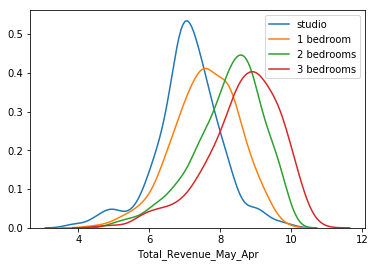

In [19]:
temp_0 = df.loc[df['bedrooms'] == 0]['Total_Revenue_May_Apr']
temp_1 = df.loc[df['bedrooms'] == 1]['Total_Revenue_May_Apr']
temp_2 = df.loc[df['bedrooms'] == 2]['Total_Revenue_May_Apr']
temp_3 = df.loc[df['bedrooms'] == 3]['Total_Revenue_May_Apr']

sns.distplot(np.log(temp_0), label = 'studio', kde = True, hist = False)
sns.distplot(np.log(temp_1), label = '1 bedroom', kde = True, hist = False)
sns.distplot(np.log(temp_2), label = '2 bedrooms', kde = True, hist = False)
sns.distplot(np.log(temp_3), label = '3 bedrooms', kde = True, hist = False)
plt.legend()

Below is breakdown of revenue differences by number of bedrooms and city.

[]

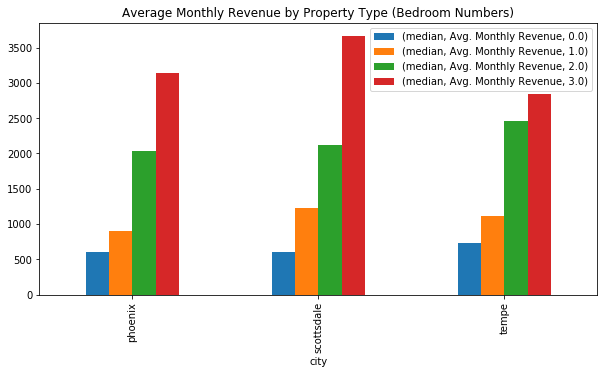

In [20]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['Total_Revenue_May_Apr'], index = ['city', 'bedrooms'],
                     aggfunc = [np.median])
temp = temp/2
temp = temp.rename(columns = {'Total_Revenue_May_Apr':'Avg. Monthly Revenue'})
temp = temp.unstack()

plt.rcParams['figure.figsize'] = [10, 5]
temp.plot(kind = 'bar')
plt.legend(loc="upper right")
plt.title('Average Monthly Revenue by Property Type (Bedroom Numbers)')
plt.plot()

In [21]:
temp

median                          
           Avg. Monthly Revenue                          
bedrooms                    0.0      1.0     2.0      3.0
city                                                     
phoenix                   600.0   900.50  2034.5  3137.25
scottsdale                607.5  1224.75  2118.0  3669.50
tempe                     737.5  1114.00  2463.0  2847.50

#### To predict revenue, we will need to consider both occupancy rate and price. Let's try to get an understanding of why 3 bedrooms gets more revenue.

#### How does occupancy rate vary by property type in each city?

In Phoenix, the property type with the highest occupancys are one bedrooms and studio, with median ocupancy between 70-80%.    In Scottsdale, the most popular property type is 1 bedroom with median occupancy of 81%.  Majority of properties in Tempe are two bedrooms, which possibly explains why the 2 bedroom occupancy rate is lower than the other property types.  

In terms of comparing 2 v.s. 3 bedrooms.  In Phoenix, there are 484 2 bedrooms, and 297 3 bedrooms.  The median occupancy ratio is 64% (2bd) vs. 72% (3bd).  However, with the high standard deviation, it is hard to drawn conclusion on which one has higher occupancy.  In Scottsdale, the occupancy rate between 2bd and 3bd is about the same, at 57%, despite having more 2 bedrooms than 3 bedrooms.  The same is true in Tempe, where there are a lot more 2 bedrooms than 3 bedrooms, while the occupancy rate is around 70%.  

In general, occupancy rate for 3 bedrooms are approximately the same as 2 bedrooms, despite having lower inventory.

In [22]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['occupancy_ratio_all'], index = ['city', 'bedrooms'],
                     aggfunc = [np.size, np.mean, np.median, np.std, np.min])
temp

size                mean  \
                    occupancy_ratio_all occupancy_ratio_all   
city       bedrooms                                           
phoenix    0.0                    113.0            0.698508   
           1.0                    471.0            0.659525   
           2.0                    467.0            0.609318   
           3.0                    282.0            0.642374   
scottsdale 0.0                     33.0            0.550554   
           1.0                    288.0            0.692489   
           2.0                    659.0            0.592282   
           3.0                    456.0            0.586111   
tempe      0.0                     17.0            0.670812   
           1.0                     74.0            0.652463   
           2.0                    155.0            0.646352   
           3.0                     75.0            0.607102   

                                 median                 std  \
                    occupancy_ratio_all occupancy_ratio_all   
city       bedrooms                                           
phoenix    0.0                 0.791667            0.295794   
           1.0                 0.708333            0.289749   
           2.0                 0.639344            0.308267   
           3.0                 0.704918            0.302152   
scottsdale 0.0                 0.541667            0.315998   
           1.0                 0.803279            0.312201   
           2.0                 0.573770            0.312601   
           3.0                 0.573770            0.313248   
tempe      0.0                 0.791667            0.291923   
           1.0                 0.723019            0.294503   
           2.0                 0.688525            0.307241   
           3.0                 0.704918            0.308591   

                                   amin  
                    occupancy_ratio_all  
city       bedrooms                      
phoenix    0.0                 0.032787  
           1.0                 0.030303  
           2.0                 0.016393  
           3.0                 0.016393  
scottsdale 0.0                 0.098361  
           1.0                 0.016393  
           2.0                 0.016393  
           3.0                 0.016393  
tempe      0.0                 0.031250  
           1.0                 0.071429  
           2.0                 0.016393  
           3.0                 0.016393

#### How does price vary by property type?

The following shows price adjusted for cleaning fee, assuming a 3 night stay. (Daily Rate * 1/3 cleaning fee).

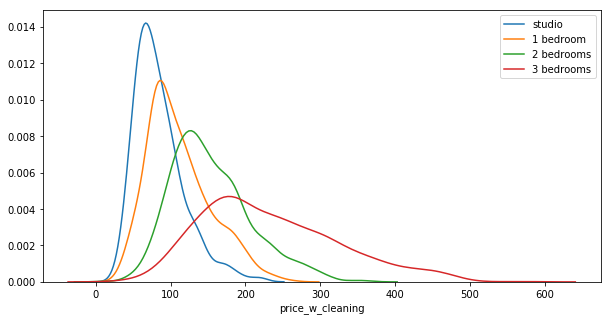

In [23]:
temp_0 = df.loc[df['bedrooms'] == 0]['price_w_cleaning']
temp_1 = df.loc[df['bedrooms'] == 1]['price_w_cleaning']
temp_2 = df.loc[df['bedrooms'] == 2]['price_w_cleaning']
temp_3 = df.loc[df['bedrooms'] == 3]['price_w_cleaning']

sns.distplot(temp_0, label = 'studio', kde = True, hist = False)
sns.distplot(temp_1, label = '1 bedroom', kde = True, hist = False)
sns.distplot(temp_2, label = '2 bedrooms', kde = True, hist = False)
sns.distplot(temp_3, label = '3 bedrooms', kde = True, hist = False)
plt.legend()

Three bedrooms definately charge higher than 2 bedrooms.

In [24]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['price_w_cleaning'], index = ['city', 'bedrooms'],
                     aggfunc = [np.mean, np.median, np.std, np.min, np.max])
temp

mean           median              std  \
                    price_w_cleaning price_w_cleaning price_w_cleaning   
city       bedrooms                                                      
phoenix    0.0             78.216365        73.000000        27.612728   
           1.0            101.975429        92.000001        38.789053   
           2.0            146.312399       137.385967        52.882873   
           3.0            203.543648       187.083334        82.697179   
scottsdale 0.0            105.802860        97.533334        41.017945   
           1.0            124.082894       115.500003        43.026740   
           2.0            161.220075       150.177306        55.054379   
           3.0            256.960709       245.715388        90.621473   
tempe      0.0             88.240309        83.333334        33.277340   
           1.0            122.115268       121.083334        45.908413   
           2.0            147.316289       141.028249        42.621872   
           3.0            197.967185       180.000000        78.697016   

                                amin             amax  
                    price_w_cleaning price_w_cleaning  
city       bedrooms                                    
phoenix    0.0             35.000000       170.000000  
           1.0             33.608696       244.067797  
           2.0             10.000000       311.428571  
           3.0             38.333333       470.480231  
scottsdale 0.0             54.275364       218.483333  
           1.0             40.000000       263.476193  
           2.0             46.368421       364.520000  
           3.0             96.666668       565.666667  
tempe      0.0             54.894737       175.000000  
           1.0             43.458333       234.000000  
           2.0             65.583333       299.000000  
           3.0             71.000000       450.000000

The following shows price excluding cleaning fee.

In [25]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['mean_price'], index = ['city', 'bedrooms'],
                     aggfunc = [np.mean, np.median, np.std, np.min, np.max])
temp

mean      median        std       amin        amax
                     mean_price  mean_price mean_price mean_price  mean_price
city       bedrooms                                                          
phoenix    0.0        67.735538   61.480769  27.039036  23.000000  159.220339
           1.0        85.718529   77.000000  36.716016  29.000000  200.000000
           2.0       118.522962  107.083333  48.033562  10.000000  258.833333
           3.0       163.731590  148.704082  71.730013  38.333333  399.000000
scottsdale 0.0        93.136193   90.035714  37.452556  37.608696  168.483333
           1.0        98.991458   86.853409  41.009802  35.000000  225.000000
           2.0       120.599942  108.510638  49.785376  36.000000  267.000000
           3.0       203.657345  189.451271  84.805565  52.285714  423.728814
tempe      0.0        78.240309   75.000000  33.391312  45.727273  175.000000
           1.0       103.687339   94.653061  45.617449  25.000000  209.000000
           2.0       120.875428  111.333333  43.216047  47.744186  249.000000
           3.0       158.207184  139.000000  75.191980  71.000000  400.000000

Below shows the cleaning fee.  Three bedrooms charges higher cleaning fee.  

In [26]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['cleaning_fee'], index = ['bedrooms'],
                     aggfunc = [ np.mean, np.median, np.std, np.min, np.max])
temp

,mean,median,std,amin,amax
,cleaning_fee,cleaning_fee,cleaning_fee,cleaning_fee,cleaning_fee
bedrooms,,,,,
0.0,32.619633,30.0,27.540813,0.0,150.0
1.0,58.512604,50.0,47.993740,0.0,300.0
2.0,102.680717,100.0,64.846115,0.0,460.0
3.0,142.123001,140.0,85.004631,0.0,500.0


### How much value does having a pool add to the property?

Having a pool definatley can charge more.

In [27]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['price_w_cleaning'], index = ['has_pool'],
                     aggfunc = [np.median])
temp

,median
,price_w_cleaning
has_pool,
0,115.383333
1,151.617249


Having a pool also generates more revenue.

In [28]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['Total_Revenue_May_Apr'], index = ['has_pool'],
                     aggfunc = [np.median])
temp

,median
,Total_Revenue_May_Apr
has_pool,
0,2992.5
1,3956.0


However, the occupancy ratio is approximately the same between having a pool or not.

In [29]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['occupancy_ratio_all'], index = ['has_pool'],
                     aggfunc = [np.mean, np.median])
temp

,mean,median
,occupancy_ratio_all,occupancy_ratio_all
has_pool,,
0,0.637418,0.666667
1,0.622304,0.655738


#### Here is a more complicated breakdown of pricing.

In [30]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) & (df['bedrooms'] <= 3)]
temp = pd.pivot_table(subset, values = ['price_w_cleaning'], index = ['city', 'bedrooms', 'has_pool'],
                     aggfunc = [np.mean, np.median])
temp

mean           median
                             price_w_cleaning price_w_cleaning
city       bedrooms has_pool                                  
phoenix    0.0      0               71.457422        67.666667
                    1               93.279151        86.807018
           1.0      0               94.007632        84.876842
                    1              109.579552       101.190477
           2.0      0              132.632711       122.458334
                    1              153.307191       141.666668
           3.0      0              191.416746       171.666668
                    1              212.924837       193.529412
scottsdale 0.0      0               81.081230        77.883334
                    1              118.163675       108.151516
           1.0      0              118.464809       112.333334
                    1              124.711946       116.041668
           2.0      0              172.091312       159.650003
                    1              160.554846       150.000000
           3.0      0              229.595801       215.869565
                    1              264.746217       252.555557
tempe      0.0      0               75.062664        61.666667
                    1               97.464661        97.000001
           1.0      0               79.033179        77.851866
                    1              140.342306       138.093074
           2.0      0              125.512947       131.151516
                    1              153.675597       149.833334
           3.0      0              187.444120       182.528197
                    1              202.919216       176.166672

### How much value does having more bathrooms add value to the property?

Having more than 1 bathroom always adds value.  However, the effect diminishes (adds less value) when having more than 2 bathrooms.  

In [31]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) 
                & (df['bedrooms'] <= 3) & (df['bedrooms'] >= 1)]
temp = pd.pivot_table(subset, values = ['price_w_cleaning'], index = ['bedrooms', 'bathrooms'],
                     aggfunc = [np.size, np.median])
temp

size           median
                   price_w_cleaning price_w_cleaning
bedrooms bathrooms                                  
1.0      1.0                  801.0       101.190477
         1.5                   19.0       141.666668
         2.0                   13.0       124.000000
2.0      1.0                  219.0       114.384615
         1.5                   92.0       128.302791
         2.0                  883.0       152.047620
         2.5                   78.0       171.323531
         3.0                    7.0       175.000000
         3.5                    1.0       136.666672
         4.0                    1.0       250.000000
3.0      1.0                   25.0       138.333333
         1.5                   20.0       149.944807
         2.0                  567.0       217.000003
         2.5                  122.0       229.100001
         3.0                   58.0       249.763160
         3.5                   21.0       291.047624

### How does price vary from the different days of week?

As expected, weekend costs more.

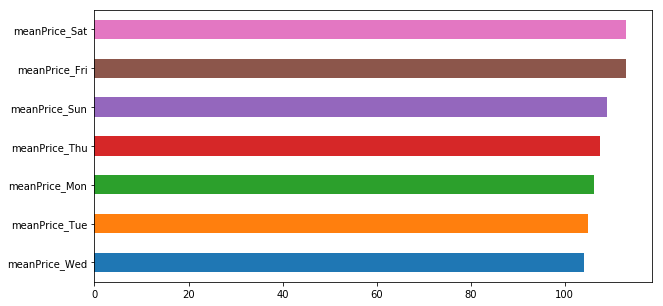

In [32]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) 
                & (df['bedrooms'] <= 3)]

chart = subset[['meanPrice_Fri', 'meanPrice_Mon', 'meanPrice_Sat', 'meanPrice_Sun', 
            'meanPrice_Thu', 'meanPrice_Tue','meanPrice_Wed']].median().nsmallest(7).plot(kind = 'barh')

April was more expensive than May.

Text(0.5,1,'Mean Price of Properties in May and April')

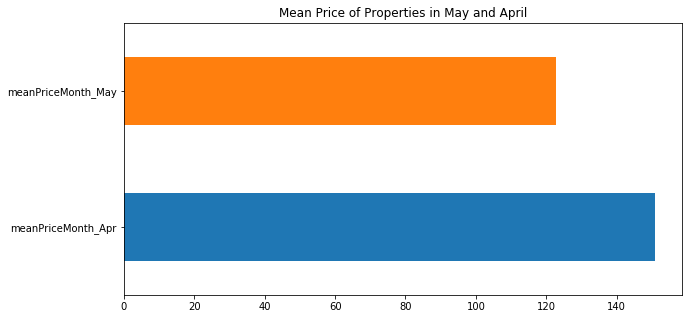

In [33]:
chart = df[['meanPriceMonth_Apr', 'meanPriceMonth_May']].median().plot(kind = 'barh')
plt.title('Mean Price of Properties in May and April')

Text(0.5,1,'Mean price of properties by month and day of week')

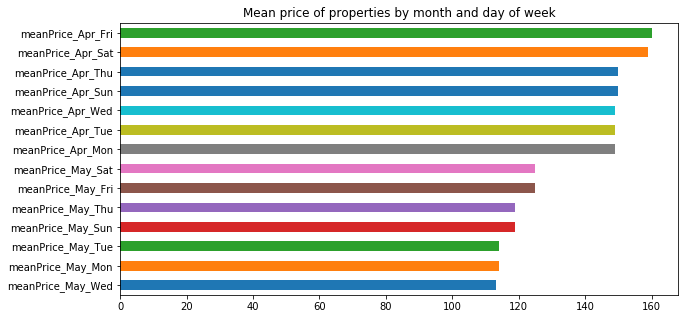

In [34]:
cols = ['meanPrice_Apr_Fri', 'meanPrice_Apr_Mon',
       'meanPrice_Apr_Sat', 'meanPrice_Apr_Sun', 'meanPrice_Apr_Thu',
       'meanPrice_Apr_Tue', 'meanPrice_Apr_Wed', 'meanPrice_May_Fri',
       'meanPrice_May_Mon', 'meanPrice_May_Sat', 'meanPrice_May_Sun',
       'meanPrice_May_Thu', 'meanPrice_May_Tue', 'meanPrice_May_Wed']
chart = df[cols].median().nsmallest(14).plot(kind = 'barh')
plt.title('Mean price of properties by month and day of week')

### What is the most popular property type on the platform in each location?

Text(0.5,1,'Number of Active Properties by City')

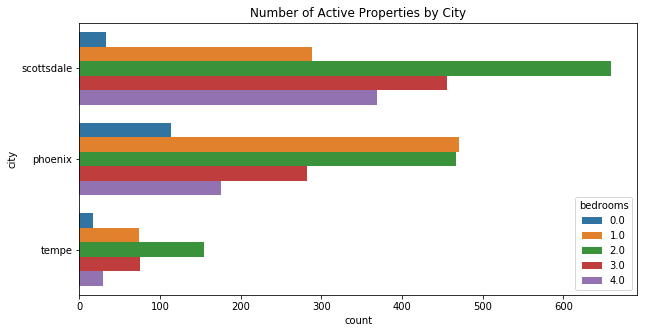

In [35]:
subset = df.loc[(df['city'].isin(['phoenix', 'tempe', 'scottsdale'])) 
                & (df['bedrooms'] <= 4)]

sns.countplot(y="city", hue="bedrooms", data=subset)
plt.title('Number of Active Properties by City')

### How many properties does each manager manage and what is the number of listings with active bookings?

Active as determined by if there were bookings in April or May.

In [36]:
temp = listing.loc[listing['host_name'].isin(managers)]
temp = pd.crosstab(temp['host_name'], temp['exclude'], margins = True)
temp.columns = ['Active', 'Not Active', 'Total']
temp

,Active,Not Active,Total
host_name,,,
Casago,64,64,128
Evolve Vacation Rental,151,184,335
HitRentals,24,8,32
Latitude 8,3,30,33
Meridian CondoResorts,34,9,43
My Rental Advisor,14,3,17
Pro Housing,12,10,22
Red Awning,23,28,51
RentalAdvisor,0,17,17


### How many days in advance do people make a booking?

44% of the bookings are made within a day of the stay date.

In [37]:
price['booking_num_days_ahead'].value_counts(normalize = True).nlargest(10)

0.0    0.287807
1.0    0.168161
2.0    0.092855
6.0    0.074570
3.0    0.024349
5.0    0.023076
4.0    0.022498
7.0    0.017983
8.0    0.016802
9.0    0.015266
Name: booking_num_days_ahead, dtype: float64

### What is the day of the week that most bookings are made?

Most bookings are made on Tuesday, and least on the weekends.

In [38]:
price['booked_date_weekday'].value_counts(normalize = True).nlargest(7)

Tue    0.172444
Mon    0.160677
Thu    0.155797
Sun    0.151738
Wed    0.139971
Fri    0.115890
Sat    0.103484
Name: booked_date_weekday, dtype: float64

### What is the average number of days per stay?

Majority of the stays are just for one day.

In [39]:
price['num_days_booked'].value_counts(normalize = True)

1.0     0.518607
2.0     0.088904
3.0     0.085085
4.0     0.073153
5.0     0.056181
7.0     0.039865
6.0     0.038893
8.0     0.021540
9.0     0.016473
11.0    0.014045
10.0    0.013861
13.0    0.012155
12.0    0.011551
14.0    0.009687
Name: num_days_booked, dtype: float64

### What are the most important features of pricing?

From running a quick model, the number of bedrooms is the primary factor to determine the price of the property, followed by location.

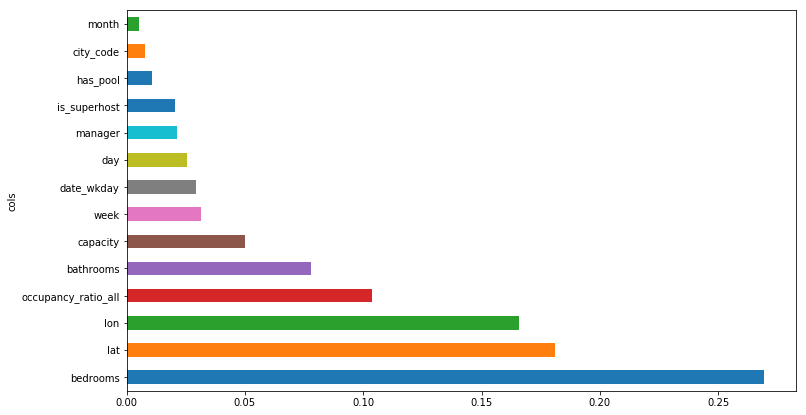

In [41]:
fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

### What is the relationship between price and occupancy rate?

A slight negative relationship is observed between price and occupancy rate.

Text(0.5,1,'One Bedroom Price to Occupancy Rate')

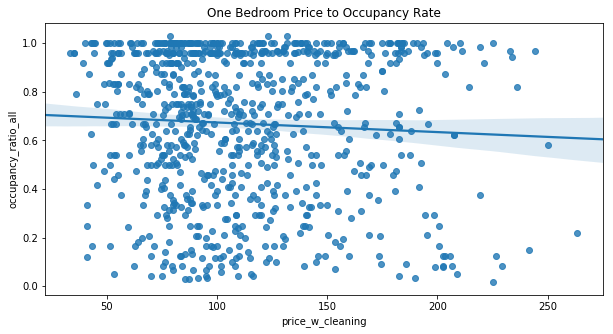

In [52]:
subset = df.loc[(df['bedrooms'] == 1)]
sns.regplot(x='price_w_cleaning', y='occupancy_ratio_all', data=subset)
plt.title('One Bedroom Price to Occupancy Rate')

Text(0.5,1,'Two Bedrooms Price to Occupancy Rate')

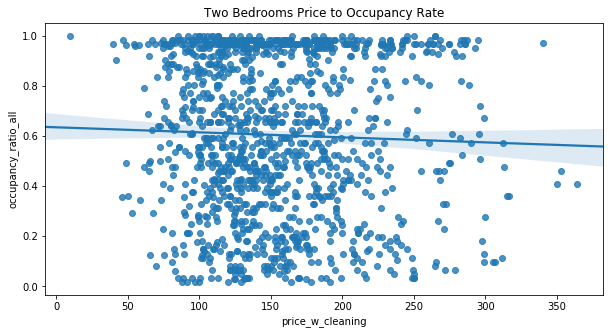

In [53]:
subset = df.loc[(df['bedrooms'] == 2)]
sns.regplot(x='price_w_cleaning', y='occupancy_ratio_all', data=subset)
plt.title('Two Bedrooms Price to Occupancy Rate')

### How concentrated are the  properties located in Arizona?

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


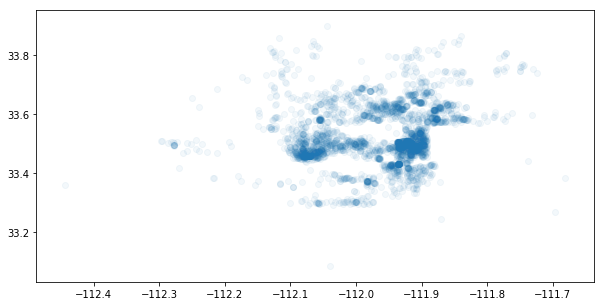

In [42]:
subset = df.loc[(df['bedrooms'] <= 4)]

subset['bedrooms'] = subset['bedrooms'].astype(str)
plt.scatter(x= subset['lon'], y = subset['lat'], alpha = 0.05)

## Setup

This sections contains the code that needs to be run prior to the Introduction section.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from fastai.structured import *
from fastai.column_data import *

PATH = "data/wanderjaunt/"

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
price = pd.read_pickle(PATH+'/price.pkl')
listing = pd.read_pickle(PATH+'/listing.pkl')

df = listing.loc[listing['exclude'] == 0].copy()

managers = ['Evolve Vacation Rental', 'Stay Alfred', 'Casago', 'WanderJaunt', 'Red Awning', 
            'Elite Vacation Rental', 'Meridian CondoResorts',
           'Scottsdale', 'Latitude 8', 'HitRentals', 'Pro Housing', 'RentalAdvisor',  'My Rental Advisor']


#### Remove properties with bad price data.

Using 95% percentile as tolerance.

In [2]:
temp_0 = df.loc[df['bedrooms'] == 0]['mean_price']
temp_1 = df.loc[df['bedrooms'] == 1]['mean_price']
temp_2 = df.loc[df['bedrooms'] == 2]['mean_price']
temp_3 = df.loc[df['bedrooms'] == 3]['mean_price']

In [3]:
x_0 = np.percentile(temp_0, 95)
x_1 = np.percentile(temp_1, 95)
x_2 = np.percentile(temp_2, 95)
x_3 = np.percentile(temp_3, 95)

In [4]:
df.loc[(df['bedrooms'] == 0) & (df['mean_price'] > x_0), 'exclude'] = 1
df.loc[(df['bedrooms'] == 1) & (df['mean_price'] > x_1), 'exclude'] = 1
df.loc[(df['bedrooms'] == 2) & (df['mean_price'] > x_2), 'exclude'] = 1
df.loc[(df['bedrooms'] == 3) & (df['mean_price'] > x_3), 'exclude'] = 1

df = df.loc[df['exclude'] == 0].copy()

In [5]:
listing.loc[~listing['scraping_id'].isin(df['scraping_id']), 'exlude'] = 1

#### Quick model to understand the factors for pricing

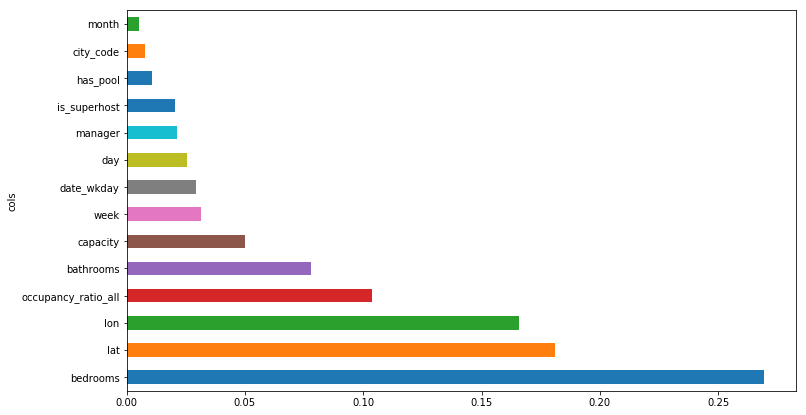

In [6]:
cols = ['scraping_id', 'date', 'date_wkday', 
       'week', 'day', 'month', 'manager', 
       'calc_price_w_cleanFee']
valid_properties = df['scraping_id'].unique()
data = price.loc[price['scraping_id'].isin(valid_properties), cols]
cols = ['scraping_id', 'city', 'lon', 'lat', 'capacity', 'bathrooms', 'bedrooms', 'has_pool', 'cleaning_fee',
       'is_superhost', 'bed_bath_ratio', 'occupancy_ratio_all']
data = data.merge(listing[cols], how = 'left', on = 'scraping_id')
data = data.loc[(data['city'].isin(['scottsdale', 'tempe', 'phoenix'])) & (data['bedrooms'] <= 3)]
data['city'] = pd.Categorical(data['city'])
data['city_code'] = data['city'].cat.codes
data['city_code'] = data['city_code'].astype('float32')
def downcast_dtypes(df):

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float32"]
    int_cols =   [c for c in df if df[c].dtype == "int32"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df
data = downcast_dtypes(data)
cols = [x for x in data.columns if x not in ['date', 'calc_price_w_cleanFee','scraping_id', 'city', 'bed_bath_ratio', 'cleaning_fee']]

X_train = data[cols].reset_index(drop = True)
y_train = data['calc_price_w_cleanFee'].reset_index(drop = True)

m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)

fi = rf_feat_importance(m, X_train)
fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#### How many properties are on the listing file.  How many of them are active (have booking in either April or May)

Approximately half of the listings did not have active booking.

In [7]:
listing['exclude'].value_counts(normalize = True)

1    0.510716
0    0.489284
Name: exclude, dtype: float64

#### Understanding properties in each city?

In [8]:
city_property_count = df['city'].value_counts()
city_mean_price = df.groupby('city')['mean_price'].mean().sort_values(ascending = False)
city_property_percentage = df['city'].value_counts(normalize = True)

In [9]:
city = pd.DataFrame()

In [10]:
city['city_property_percentage'] = city_property_percentage
city['city_property_count'] = city_property_count
city['city_mean_price'] = city_mean_price

In [11]:
city

,city_property_percentage,city_property_count,city_mean_price
scottsdale,0.508821,2019,237.571320
phoenix,0.396673,1574,155.773599
tempe,0.090474,359,154.953049
mesa,0.001008,4,116.250000
fountain hills,0.000504,2,283.000000
peoria,0.000504,2,152.500000
paradise valley,0.000504,2,747.500000
chandler,0.000252,1,279.000000
anthem,0.000252,1,250.000000
goodyear,0.000252,1,196.000000


#### Where are WanderJaunt Properties located?

In [12]:
df[df['host_name']=='WanderJaunt'].groupby('city').size()

city
phoenix       19
scottsdale    23
tempe          6
dtype: int64

In [13]:
df.groupby('city')['mean_price'].mean().sort_values(ascending = False)

city
paradise valley    747.500000
fountain hills     283.000000
chandler           279.000000
anthem             250.000000
scottsdale         237.571320
goodyear           196.000000
maricopa           169.000000
phoenix            155.773599
tempe              154.953049
peoria             152.500000
glendale           149.000000
mesa               116.250000
gilbert             84.000000
Name: mean_price, dtype: float64